## Introduction and plan



### 1. Dataset Selection

We have chosen the Fashion-MNIST dataset. It consists of 70,000 grayscale images (28x28 pixels) categorized into 10 classes of clothing and accessories. This dataset serves as a more challenging replacement for the original MNIST digits dataset, requiring the model to learn more complex textures and shapes.

### 2. Pretraining Model Selection

- Model: ConvNeXt (tiny) — chosen for transfer learning.
- Justification: ConvNeXt is a modern convolutional architecture that improves on many design choices while keeping the efficient convolutional inductive bias. The "tiny" variant is lightweight and fast, which is suitable for our dataset and compute budget; its pretrained ImageNet features transfer well to Fashion-MNIST. We use feature extraction (freeze base, train classifier) as a robust transfer strategy.

### 3. Transfer Learning Strategy

- Approach: We will use feature extraction by freezing the convolutional base of ConvNeXt (tiny).

- Justification: Freezing the convolutional base allows us to leverage the learned ImageNet features while only training the final classifier on our specific dataset. This reduces training time and computational resources while still achieving good performance.

- Modifications: We will replace the final classifier of ConvNeXt with a new linear layer tailored to the 10 classes of the Fashion-MNIST dataset.

- Training: We will train the new classification layer using the Fashion-MNIST training set while keeping the convolutional base frozen. After the initial training of the classification head, we may unfreeze the final blocks and continue training with a lower learning rate to refine the model for fashion-specific textures.

- Hyperparameters: We will use a learning rate of 0.001 for the classification head and 0.0001 for fine-tuning, with a batch size of 32 and training for 10 epochs initially.

- Optimization: We will use the Adam optimizer for its adaptive learning rate capabilities, which is beneficial for transfer learning scenarios.



### 4. Preprocessing & Augmentation Strategy

- Resize & RGB Conversion: Since the pretrained ConvNeXt models were trained on ImageNet (color images), we will resize the 28x28 images to 224x224 and convert grayscale to 3-channel RGB.

- Augmentation: We will use RandomHorizontalFlip and RandomRotation to increase model robustness and prevent overfitting.

- Normalization: We will normalize the pixel values using the standard ImageNet mean and standard deviation to align with the pretrained weights

### 5. Evaluation Metrics

We will monitor Cross-Entropy Loss and Accuracy. We will use TensorBoard to log these metrics for every run to ensure a fair comparison between the pretrained model and the CNN from scratch.

## Data exploration and preprocessing

We will implement the preprocessing and augmentation strategies outlined in our planning phase. This includes resizing, converting to RGB, applying augmentations, and normalizing the images.

Import necessary libraries

Make sure tensorboard is installed (pip install tensorboard)

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torch.nn.functional as F

#### 1. Setup TensorBoard writer

In [12]:
writer = SummaryWriter('logs/fashion_mnist_experiments')

#### 2. Define Transforms

We resize to 224 for the pretrained model and convert to 3 channels 

In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.Grayscale(num_output_channels=3),  # Pretrained models expect 3 channels
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet standards
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#### 3. Load Dataset

In [14]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=data_transforms['train'])
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


#### 4. Exploratory Data Analysis (EDA) - Visualizing the data

Get some random training images

In [15]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

Show images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


GroundTruth:  Sandal Coat Trouser T-shirt/top


<Figure size 1000x500 with 0 Axes>

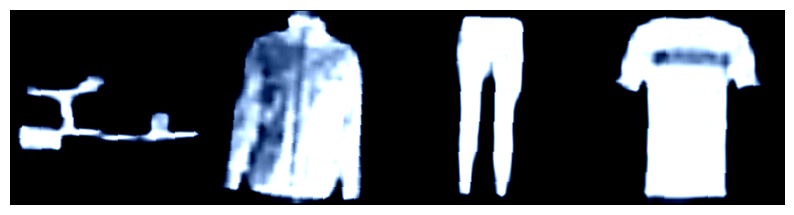

In [16]:
plt.figure(figsize=(10, 5))
print('GroundTruth: ', ' '.join(f'{train_dataset.classes[labels[j]]}' for j in range(4)))
grid = torchvision.utils.make_grid(images[:4])
npimg = grid.numpy()

plt.figure(figsize=(10, 5))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.axis('off')
plt.show()

Model Definition

In [17]:
from torchvision import models

# Load pretrained ConvNeXt Tiny
model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

# Freeze all convolutional layers (feature extraction)
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier head
num_features = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_features, 10)

# Move model to device
model = model.to(device)

print(model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [18]:
# === Environment, Splits, and Additional Imports ===
import os
import copy
import time
import torch
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm
import pandas as pd
from torch.utils.tensorboard import SummaryWriter

# Reproducibility
torch.manual_seed(42)

# Create train/validation split from the existing `train_dataset`
val_fraction = 0.1
val_size = int(val_fraction * len(train_dataset))
train_size = len(train_dataset) - val_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Replace train loader with subset and create val_loader
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

print(f"Train size: {train_size}, Val size: {val_size}, Test size: {len(test_dataset)}")

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

sample_inputs, sample_labels = next(iter(train_loader))
sample_inputs = sample_inputs.to(device)

with torch.no_grad():
    sample_outputs = model(sample_inputs[:4])

print('Output shape (batch 4):', sample_outputs.shape)

Train size: 54000, Val size: 6000, Test size: 10000
Using device: cuda
Output shape (batch 4): torch.Size([4, 10])


## Baseline model

#### Training utilities & logging

The notebook includes helper functions for training, evaluation, checkpointing, and plotting.

- **train_model**: trains the model, logs metrics to TensorBoard (when a writer is supplied), and keeps the best model by validation accuracy.
- **evaluate_model**: computes loss and accuracy on a dataloader.
- **save_checkpoint**: stores model and optimizer state along with training history under `saved_models/`.
- **plot_history**: convenience plotting for loss and accuracy curves.

All experiments below follow the same protocol: feature-extract ConvNeXt (freeze base), train the classifier head, log to `logs/`, and save the best checkpoints to `saved_models/`.

In [19]:
import os
import copy
from tqdm import tqdm
import torch
import torch.nn as nn

__all__ = [
    'load_pretrained_convnext',
    'save_checkpoint',
    'evaluate_model',
    'train_model',
    'plot_history'
]


def load_pretrained_convnext(num_classes=10, freeze_base=True, pretrained=True, variant='tiny'):
    """Minimal ConvNeXt tiny loader used in this notebook.

    - Supports only the 'tiny' variant (used everywhere in this notebook).
    - Uses the `weights=` enum API when pretrained=True for explicit reproducibility.
    - Freezes the base if requested and replaces the final classifier's last
      Linear layer with a new Linear(num_classes).
    """
    if variant != 'tiny':
        raise ValueError("Only the 'tiny' variant is supported in this notebook")

    # Import lazily to keep startup light
    from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

    weights = ConvNeXt_Tiny_Weights.DEFAULT if pretrained else None
    model = convnext_tiny(weights=weights)

    if freeze_base:
        for p in model.parameters():
            p.requires_grad = False

    # Replace last Linear in classifier (typical ConvNeXt structure)
    cls = model.classifier
    if isinstance(cls, nn.Sequential):
        # find last Linear module and replace it; fail loudly if it's not present
        for i in range(len(cls) - 1, -1, -1):
            if isinstance(cls[i], nn.Linear):
                in_features = cls[i].in_features
                cls[i] = nn.Linear(in_features, num_classes)
                model.classifier = cls
                break
        else:
            raise ValueError(
                "Could not find a `nn.Linear` module in the classifier `nn.Sequential`. "
                "Please inspect `model.classifier` and update `load_pretrained_convnext` accordingly."
            )
    elif isinstance(cls, nn.Linear):
        model.classifier = nn.Linear(cls.in_features, num_classes)
    else:
        raise ValueError(
            f"Unexpected classifier type {type(cls)}. Expected `nn.Sequential` containing a `nn.Linear` or a single `nn.Linear`. "
            "Inspect `model.classifier` and adapt the loader."
        )

    return model


def save_checkpoint(model, optimizer, epoch, history, save_path):
    """Save a checkpoint containing model and optimizer states and history."""
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history
    }, save_path)


def evaluate_model(model, dataloader, device):
    """Evaluate model on a dataloader and return loss and accuracy."""
    model.eval()
    running_corrects = 0
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc.item()


def train_model(model, criterion, optimizer, train_loader, val_loader,
                num_epochs, device, writer=None, run_name='run'):
    """Train model and optionally log to a TensorBoard writer.

    Returns the best model (by validation accuracy) and a history dict.
    """
    model = model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader, desc='Training'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation
        val_loss, val_acc = evaluate_model(model, val_loader, device)

        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc.item())
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if writer is not None:
            writer.add_scalar(f'{run_name}/Loss/train', epoch_train_loss, epoch)
            writer.add_scalar(f'{run_name}/Loss/val', val_loss, epoch)
            writer.add_scalar(f'{run_name}/Accuracy/train', epoch_train_acc, epoch)
            writer.add_scalar(f'{run_name}/Accuracy/val', val_acc, epoch)

        print(f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # deep copy the best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, history


def plot_history(history, label_prefix='Baseline'):
    """Return a matplotlib figure plotting loss and accuracy from history dict."""
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].plot(history['train_loss'], label=f'{label_prefix} - Train')
    axes[0].plot(history['val_loss'], label=f'{label_prefix} - Val')
    axes[0].set_title(f'{label_prefix} Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history['train_acc'], label=f'{label_prefix} - Train')
    axes[1].plot(history['val_acc'], label=f'{label_prefix} - Val')
    axes[1].set_title(f'{label_prefix} Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    axes[1].grid(True)
    plt.tight_layout()
    return fig

In [20]:
print('\nSanity check: build ConvNeXt (tiny) and run a forward pass on one batch (using local loader)')
convnext_variant = 'tiny'
model = load_pretrained_convnext(num_classes=10, freeze_base=True, pretrained=True, variant=convnext_variant)
model = model.to(device)
model.eval()
with torch.no_grad():
    sample_outputs = model(sample_inputs[:4])
print('Selected model: convnext (variant=', convnext_variant, ') Output shape (batch 4):', sample_outputs.shape)


Sanity check: build ConvNeXt (tiny) and run a forward pass on one batch (using local loader)
Selected model: convnext (variant= tiny ) Output shape (batch 4): torch.Size([4, 10])


### Baseline — smoke test (1 epoch)

Quick smoke test to verify the training loop runs end-to-end.

Settings: feature extraction (freeze base), Adam optimizer, LR=0.001, batch size 32, 1 epoch. We log to `logs/baseline_convnext_smoke` and save a checkpoint to `saved_models/baseline_convnext_smoke/`.

In [21]:
num_epochs = 1
model = load_pretrained_convnext(num_classes=10, freeze_base=True, pretrained=True, variant='tiny')
trainable_params = [p for p in model.parameters() if p.requires_grad]
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(trainable_params, lr=0.001)

baseline_writer = SummaryWriter('logs/baseline_convnext_smoke')

print('\nStarting 1-epoch baseline (feature-extract ConvNeXt tiny) smoke test')
model, baseline_smoke_history = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    device=device,
    writer=baseline_writer,
    run_name='baseline_convnext_smoke'
)

save_checkpoint(model, optimizer, num_epochs, baseline_smoke_history,
                'saved_models/baseline_convnext_smoke/checkpoint.pth')
baseline_writer.close()

baseline_model = model
baseline_history = baseline_smoke_history
print('\n1-epoch baseline finished; history keys:', list(baseline_history.keys()))


Starting 1-epoch baseline (feature-extract ConvNeXt tiny) smoke test

Epoch 1/1


Training: 100%|██████████| 1688/1688 [03:16<00:00,  8.61it/s]


Train Loss: 0.4213 Acc: 0.8553
Val   Loss: 0.3372 Acc: 0.8773

1-epoch baseline finished; history keys: ['train_loss', 'train_acc', 'val_loss', 'val_acc']


### Full Baseline — 10 epochs

Full baseline run using feature extraction to get reliable validation metrics.

Settings: Adam optimizer, LR=0.001, batch size 32, 10 epochs. Logs: `logs/baseline_convnext`. Checkpoint: `saved_models/baseline_convnext/`.

In [22]:
num_epochs = 10
model = load_pretrained_convnext(num_classes=10, freeze_base=True, pretrained=True, variant='tiny')
trainable_params = [p for p in model.parameters() if p.requires_grad]
criterion = nn.CrossEntropyLoss()
baseline_optimizer = optim.Adam(trainable_params, lr=0.001)

baseline_writer = SummaryWriter('logs/baseline_convnext')

print('\nStarting full baseline (feature-extract ConvNeXt tiny) 10-epoch run')
baseline_model, baseline_history = train_model(
    model=model,
    criterion=criterion,
    optimizer=baseline_optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    device=device,
    writer=baseline_writer,
    run_name='baseline_convnext'
)

save_checkpoint(baseline_model, baseline_optimizer, num_epochs, baseline_history,
                'saved_models/baseline_convnext/checkpoint.pth')
baseline_writer.close()

print('\nBaseline training finished. Final Val Acc:', baseline_history['val_acc'][-1])


Starting full baseline (feature-extract ConvNeXt tiny) 10-epoch run

Epoch 1/10


Training: 100%|██████████| 1688/1688 [03:21<00:00,  8.38it/s]


Train Loss: 0.4180 Acc: 0.8569
Val   Loss: 0.3317 Acc: 0.8795

Epoch 2/10


Training: 100%|██████████| 1688/1688 [03:16<00:00,  8.57it/s]


Train Loss: 0.3182 Acc: 0.8862
Val   Loss: 0.3055 Acc: 0.8917

Epoch 3/10


Training: 100%|██████████| 1688/1688 [03:22<00:00,  8.34it/s]


Train Loss: 0.2963 Acc: 0.8933
Val   Loss: 0.2896 Acc: 0.8968

Epoch 4/10


Training: 100%|██████████| 1688/1688 [03:21<00:00,  8.39it/s]


Train Loss: 0.2880 Acc: 0.8965
Val   Loss: 0.2851 Acc: 0.8953

Epoch 5/10


Training: 100%|██████████| 1688/1688 [03:14<00:00,  8.69it/s]


Train Loss: 0.2813 Acc: 0.8986
Val   Loss: 0.2873 Acc: 0.8973

Epoch 6/10


Training: 100%|██████████| 1688/1688 [03:05<00:00,  9.12it/s]


Train Loss: 0.2763 Acc: 0.9008
Val   Loss: 0.2741 Acc: 0.8993

Epoch 7/10


Training: 100%|██████████| 1688/1688 [03:04<00:00,  9.17it/s]


Train Loss: 0.2694 Acc: 0.9022
Val   Loss: 0.2776 Acc: 0.9012

Epoch 8/10


Training: 100%|██████████| 1688/1688 [03:02<00:00,  9.25it/s]


Train Loss: 0.2682 Acc: 0.9030
Val   Loss: 0.2735 Acc: 0.8987

Epoch 9/10


Training: 100%|██████████| 1688/1688 [03:01<00:00,  9.31it/s]


Train Loss: 0.2632 Acc: 0.9051
Val   Loss: 0.2673 Acc: 0.9005

Epoch 10/10


Training: 100%|██████████| 1688/1688 [02:59<00:00,  9.38it/s]


Train Loss: 0.2612 Acc: 0.9050
Val   Loss: 0.2813 Acc: 0.8968

Baseline training finished. Final Val Acc: 0.8968333333333333


#### Baseline ConvNeXt Analysis
The baseline ConvNeXt (tiny) model is trained using feature extraction. It demonstrates effective learning on the Fashion-MNIST dataset. Training accuracy increases from 85.7% to about 90.5%, while validation accuracy follows similarly, peaking around 90.1% before slightly fluctuating in later epochs. The similarity between training and validation curves during the first half of training shows good generalization and suggests that the pretrained ImageNet features transfer well to our fashion dataset.

In later epochs, training accuracy continues to improve marginally while validation accuracy stabilizes (with small variations), pointing to mild overfitting rather than a failure to generalize. The final validation accuracy of 89.68% is in line with expectations for a frozen ConvNeXt backbone. Notably, this baseline performance is competitive with, and in this run slightly stronger than, some tuned variants, indicating that the default learning rate of 0.001 is already close to optimal for this setup.

## Hyperparameter experiments

### Hyperparameter sweep — Learning Rate

We run a sweep over learning rates [0.0003, 0.01, 0.003]. Each run trains for 10 epochs, logs to `logs/lr_<lr>` and saves a checkpoint to `saved_models/tuned_convnext_lr_<lr>/`.We use these logs to compare validation accuracy and pick the best LR.

In [23]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [24]:
learning_rates = [0.0003, 0.01, 0.003]
num_epochs = 10
tuned_histories = {}

for lr in learning_rates:
    print('\n' + '=' * 60)
    print(f'TRAINING WITH LEARNING RATE: {lr}')
    print('=' * 60)

    model = load_pretrained_convnext(num_classes=10, freeze_base=True, pretrained=True, variant='tiny')
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(trainable_params, lr=lr)
    writer = SummaryWriter(f'logs/lr_{lr}')

    trained_model, history = train_model(
        model=model,
        criterion=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        device=device,
        writer=writer,
        run_name=f'lr_{lr}'
    )

    save_checkpoint(trained_model, optimizer, num_epochs, history,
                    f'saved_models/tuned_convnext_lr_{lr}/checkpoint.pth')

    tuned_histories[lr] = history
    writer.close()

    print(f"\nCompleted training with LR={lr} | Best Val Acc: {max(history['val_acc']):.4f}")

print('\nHyperparameter tuning completed.')


TRAINING WITH LEARNING RATE: 0.0003

Epoch 1/10


Training: 100%|██████████| 1688/1688 [02:59<00:00,  9.39it/s]


Train Loss: 0.5460 Acc: 0.8316
Val   Loss: 0.3840 Acc: 0.8643

Epoch 2/10


Training: 100%|██████████| 1688/1688 [02:59<00:00,  9.42it/s]


Train Loss: 0.3622 Acc: 0.8740
Val   Loss: 0.3471 Acc: 0.8723

Epoch 3/10


Training: 100%|██████████| 1688/1688 [02:59<00:00,  9.40it/s]


Train Loss: 0.3336 Acc: 0.8826
Val   Loss: 0.3221 Acc: 0.8827

Epoch 4/10


Training: 100%|██████████| 1688/1688 [02:59<00:00,  9.39it/s]


Train Loss: 0.3168 Acc: 0.8879
Val   Loss: 0.3172 Acc: 0.8855

Epoch 5/10


Training: 100%|██████████| 1688/1688 [02:59<00:00,  9.40it/s]


Train Loss: 0.3042 Acc: 0.8916
Val   Loss: 0.3082 Acc: 0.8902

Epoch 6/10


Training: 100%|██████████| 1688/1688 [02:59<00:00,  9.38it/s]


Train Loss: 0.2979 Acc: 0.8938
Val   Loss: 0.2989 Acc: 0.8897

Epoch 7/10


Training: 100%|██████████| 1688/1688 [03:00<00:00,  9.36it/s]


Train Loss: 0.2911 Acc: 0.8956
Val   Loss: 0.2932 Acc: 0.8925

Epoch 8/10


Training: 100%|██████████| 1688/1688 [03:00<00:00,  9.35it/s]


Train Loss: 0.2852 Acc: 0.8988
Val   Loss: 0.2907 Acc: 0.8962

Epoch 9/10


Training: 100%|██████████| 1688/1688 [02:59<00:00,  9.39it/s]


Train Loss: 0.2801 Acc: 0.8997
Val   Loss: 0.2875 Acc: 0.8952

Epoch 10/10


Training: 100%|██████████| 1688/1688 [03:00<00:00,  9.38it/s]


Train Loss: 0.2780 Acc: 0.9006
Val   Loss: 0.2824 Acc: 0.8933

Completed training with LR=0.0003 | Best Val Acc: 0.8962

TRAINING WITH LEARNING RATE: 0.01

Epoch 1/10


Training: 100%|██████████| 1688/1688 [03:00<00:00,  9.38it/s]


Train Loss: 0.5179 Acc: 0.8446
Val   Loss: 0.4400 Acc: 0.8750

Epoch 2/10


Training: 100%|██████████| 1688/1688 [02:59<00:00,  9.38it/s]


Train Loss: 0.4958 Acc: 0.8655
Val   Loss: 0.4413 Acc: 0.8805

Epoch 3/10


Training: 100%|██████████| 1688/1688 [03:00<00:00,  9.36it/s]


Train Loss: 0.4810 Acc: 0.8724
Val   Loss: 0.4942 Acc: 0.8783

Epoch 4/10


Training: 100%|██████████| 1688/1688 [03:00<00:00,  9.37it/s]


Train Loss: 0.4771 Acc: 0.8757
Val   Loss: 0.6175 Acc: 0.8590

Epoch 5/10


Training: 100%|██████████| 1688/1688 [03:02<00:00,  9.23it/s]


Train Loss: 0.4874 Acc: 0.8768
Val   Loss: 0.4579 Acc: 0.8872

Epoch 6/10


Training: 100%|██████████| 1688/1688 [03:00<00:00,  9.36it/s]


Train Loss: 0.4739 Acc: 0.8788
Val   Loss: 0.5566 Acc: 0.8752

Epoch 7/10


Training: 100%|██████████| 1688/1688 [03:00<00:00,  9.38it/s]


Train Loss: 0.4904 Acc: 0.8772
Val   Loss: 0.4419 Acc: 0.8965

Epoch 8/10


Training: 100%|██████████| 1688/1688 [03:00<00:00,  9.37it/s]


Train Loss: 0.4848 Acc: 0.8807
Val   Loss: 0.5170 Acc: 0.8870

Epoch 9/10


Training: 100%|██████████| 1688/1688 [03:00<00:00,  9.35it/s]


Train Loss: 0.4878 Acc: 0.8810
Val   Loss: 0.5083 Acc: 0.8805

Epoch 10/10


Training: 100%|██████████| 1688/1688 [03:00<00:00,  9.36it/s]


Train Loss: 0.4959 Acc: 0.8813
Val   Loss: 0.4743 Acc: 0.8855

Completed training with LR=0.01 | Best Val Acc: 0.8965

TRAINING WITH LEARNING RATE: 0.003

Epoch 1/10


Training: 100%|██████████| 1688/1688 [03:00<00:00,  9.35it/s]


Train Loss: 0.3876 Acc: 0.8620
Val   Loss: 0.3627 Acc: 0.8803

Epoch 2/10


Training: 100%|██████████| 1688/1688 [03:00<00:00,  9.34it/s]


Train Loss: 0.3222 Acc: 0.8854
Val   Loss: 0.3006 Acc: 0.8902

Epoch 3/10


Training: 100%|██████████| 1688/1688 [03:00<00:00,  9.35it/s]


Train Loss: 0.3109 Acc: 0.8891
Val   Loss: 0.3161 Acc: 0.8907

Epoch 4/10


Training: 100%|██████████| 1688/1688 [03:00<00:00,  9.35it/s]


Train Loss: 0.3084 Acc: 0.8912
Val   Loss: 0.3066 Acc: 0.8935

Epoch 5/10


Training: 100%|██████████| 1688/1688 [03:00<00:00,  9.36it/s]


Train Loss: 0.2999 Acc: 0.8946
Val   Loss: 0.3306 Acc: 0.8872

Epoch 6/10


Training: 100%|██████████| 1688/1688 [03:00<00:00,  9.36it/s]


Train Loss: 0.2969 Acc: 0.8953
Val   Loss: 0.3139 Acc: 0.8910

Epoch 7/10


Training: 100%|██████████| 1688/1688 [03:00<00:00,  9.35it/s]


Train Loss: 0.2938 Acc: 0.8957
Val   Loss: 0.3109 Acc: 0.8915

Epoch 8/10


Training: 100%|██████████| 1688/1688 [03:00<00:00,  9.33it/s]


Train Loss: 0.2944 Acc: 0.8966
Val   Loss: 0.2948 Acc: 0.8975

Epoch 9/10


Training: 100%|██████████| 1688/1688 [03:00<00:00,  9.34it/s]


Train Loss: 0.2893 Acc: 0.8991
Val   Loss: 0.3193 Acc: 0.8902

Epoch 10/10


Training: 100%|██████████| 1688/1688 [03:00<00:00,  9.36it/s]


Train Loss: 0.2870 Acc: 0.8993
Val   Loss: 0.3259 Acc: 0.8933

Completed training with LR=0.003 | Best Val Acc: 0.8975

Hyperparameter tuning completed.



Plotting baseline history...


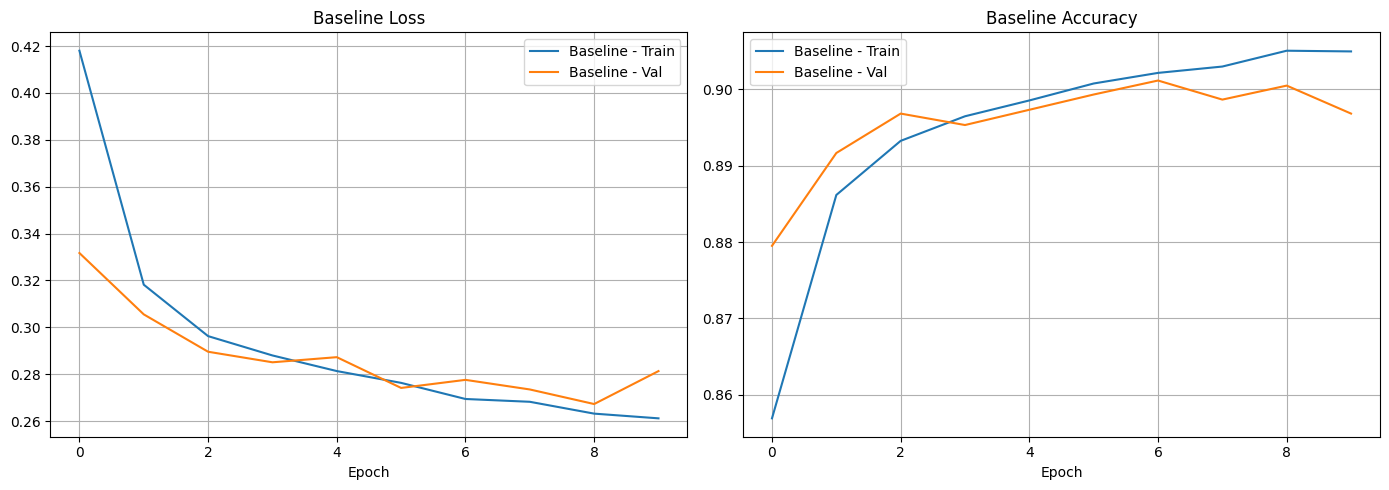


Plotting tuned models history...


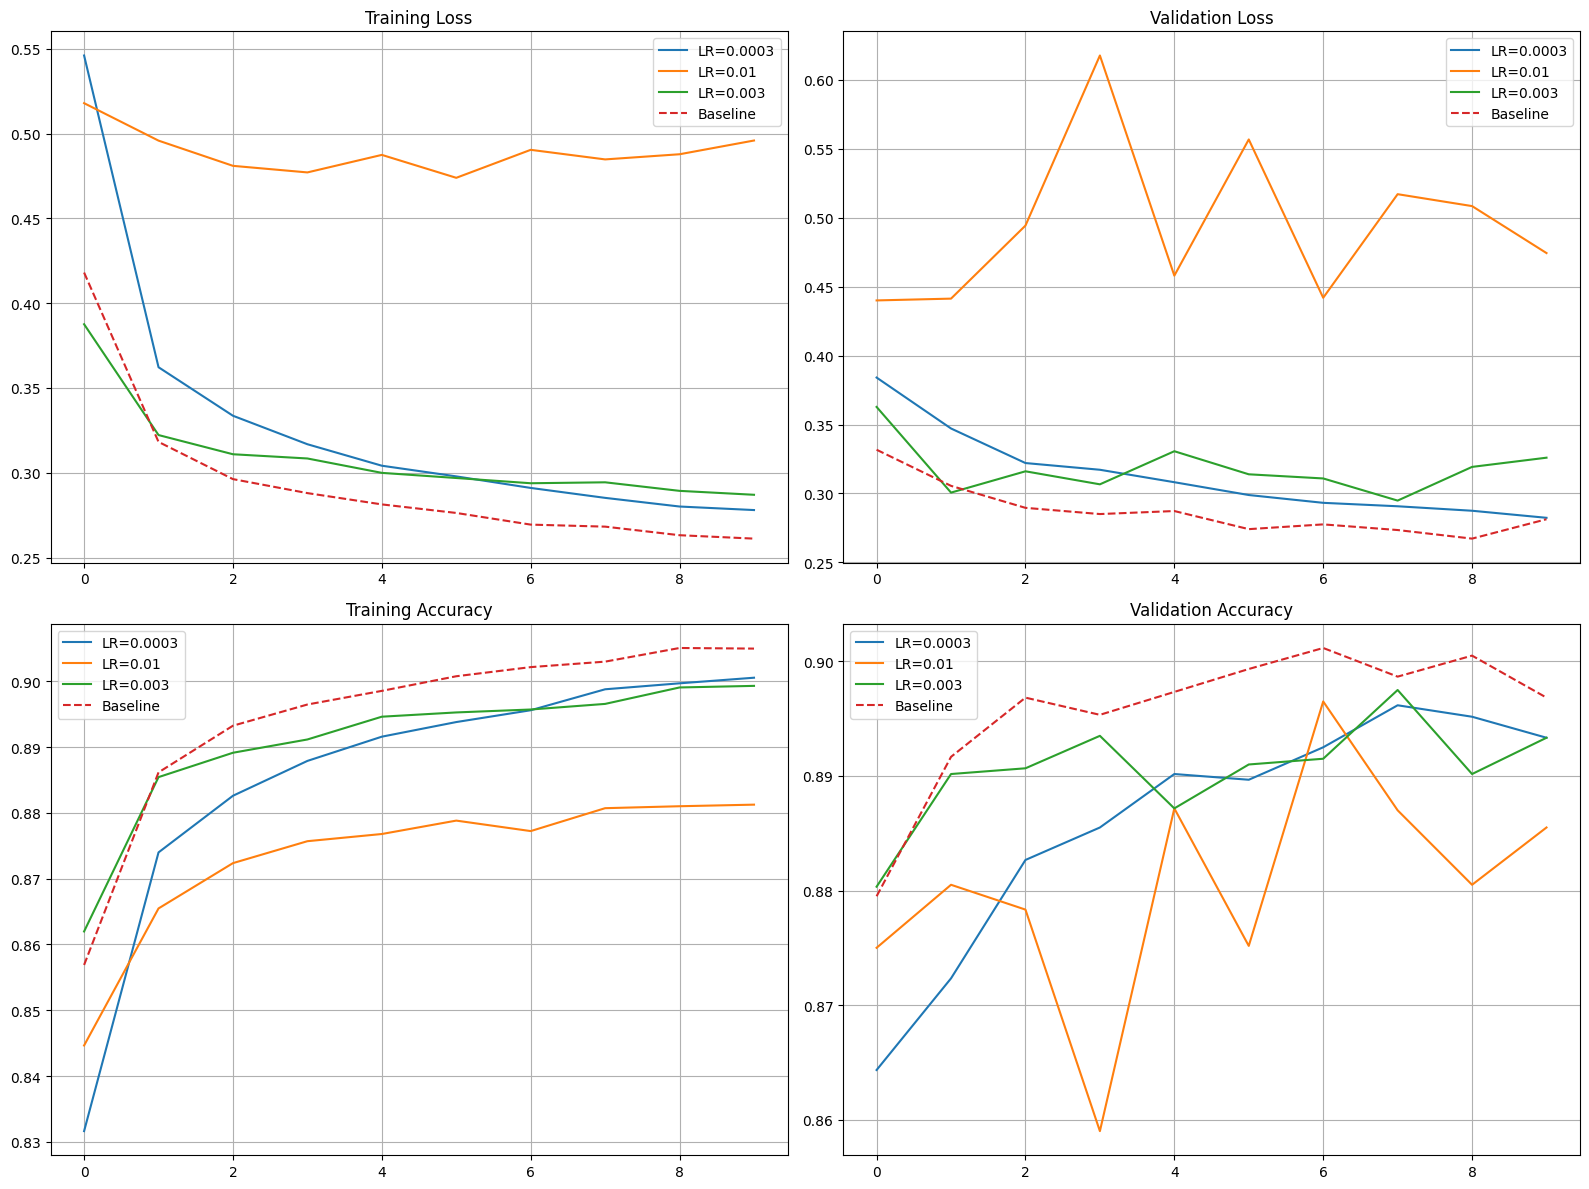

,Model,Learning Rate,Final Train Loss,Final Train Acc,Final Val Loss,Final Val Acc,Best Val Acc
0,Baseline,0.0010,0.261171,0.904981,0.281331,0.896833,0.901167
1,Tuned (LR=0.0003),0.0003,0.278011,0.900556,0.282362,0.893333,0.896167
2,Tuned (LR=0.01),0.0100,0.495887,0.881259,0.474282,0.885500,0.896500
3,Tuned (LR=0.003),0.0030,0.287020,0.899315,0.325943,0.893333,0.897500



BEST MODEL: Baseline with Best Val Acc = 0.9012


In [25]:
import matplotlib.pyplot as plt
import pandas as pd

if 'baseline_history' in globals():
    print('\nPlotting baseline history...')
    fig = plot_history(baseline_history, 'Baseline')
    fig.savefig('baseline_training_curves.png', dpi=200, bbox_inches='tight')
    plt.show()
else:
    print('\nNo baseline history found. Run the baseline training cell to generate it.')

if 'tuned_histories' in globals() and len(tuned_histories) > 0:
    print('\nPlotting tuned models history...')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()

    for lr, h in tuned_histories.items():
        axes[0].plot(h['train_loss'], label=f'LR={lr}')
    if 'baseline_history' in globals():
        axes[0].plot(baseline_history['train_loss'], label='Baseline', linestyle='--')
    axes[0].set_title('Training Loss')
    axes[0].legend()
    axes[0].grid(True)

    for lr, h in tuned_histories.items():
        axes[1].plot(h['val_loss'], label=f'LR={lr}')
    if 'baseline_history' in globals():
        axes[1].plot(baseline_history['val_loss'], label='Baseline', linestyle='--')
    axes[1].set_title('Validation Loss')
    axes[1].legend()
    axes[1].grid(True)

    for lr, h in tuned_histories.items():
        axes[2].plot(h['train_acc'], label=f'LR={lr}')
    if 'baseline_history' in globals():
        axes[2].plot(baseline_history['train_acc'], label='Baseline', linestyle='--')
    axes[2].set_title('Training Accuracy')
    axes[2].legend()
    axes[2].grid(True)

    for lr, h in tuned_histories.items():
        axes[3].plot(h['val_acc'], label=f'LR={lr}')
    if 'baseline_history' in globals():
        axes[3].plot(baseline_history['val_acc'], label='Baseline', linestyle='--')
    axes[3].set_title('Validation Accuracy')
    axes[3].legend()
    axes[3].grid(True)

    plt.tight_layout()
    plt.savefig('hyperparameter_comparison.png', dpi=200, bbox_inches='tight')
    plt.show()
else:
    print('\nNo tuned histories found. Run the hyperparameter tuning cell to generate them.')

# Summary table
if 'baseline_history' in globals() or ('tuned_histories' in globals() and len(tuned_histories) > 0):
    results_data = []
    if 'baseline_history' in globals():
        results_data.append({
            'Model': 'Baseline',
            'Learning Rate': 0.001,
            'Final Train Loss': baseline_history['train_loss'][-1],
            'Final Train Acc': baseline_history['train_acc'][-1],
            'Final Val Loss': baseline_history['val_loss'][-1],
            'Final Val Acc': baseline_history['val_acc'][-1],
            'Best Val Acc': max(baseline_history['val_acc'])
        })
    if 'tuned_histories' in globals():
        for lr, h in tuned_histories.items():
            results_data.append({
                'Model': f'Tuned (LR={lr})',
                'Learning Rate': lr,
                'Final Train Loss': h['train_loss'][-1],
                'Final Train Acc': h['train_acc'][-1],
                'Final Val Loss': h['val_loss'][-1],
                'Final Val Acc': h['val_acc'][-1],
                'Best Val Acc': max(h['val_acc'])
            })
    results_df = pd.DataFrame(results_data)
    display(results_df)
    if not results_df.empty:
        best_idx = results_df['Best Val Acc'].idxmax()
        best_model = results_df.iloc[best_idx]
        print(f"\nBEST MODEL: {best_model['Model']} with Best Val Acc = {best_model['Best Val Acc']:.4f}")
else:
    print('\nNo results to summarize yet.')

#### Learning Rate Hyperparameter tuning Analysis
The learning rate sweep shows that ConvNeXt feature extraction on Fashion-MNIST is relatively insensitive to moderate changes in learning rate. All tested values achieve validation accuracies between approximately 89% and 90%, indicating a robust training setup. The lowest learning rate (0.0003) converges more slowly and shows slightly lower peak accuracy, suggesting mild underfitting within the fixed 10-epochs.

A higher learning rate of 0.01 results in noisier training and worse validation loss, consistent with overly aggressive optimization of the classifier head. The baseline learning rate of 0.001 achieves the strongest and most stable validation performance in this run, marginally outperforming the tuned variants. Importantly, these small differences fall within expected stochastic variation, and the experiment confirms that the baseline configuration was already well chosen rather than poorly optimized.


## Grad-CAM and Misclassification

To interpret the predictions of the pretrained ConvNeXt model, we apply Grad-CAM
to visualize which image regions most strongly influence the model's decisions.

In [46]:
def clear_all_hooks(model):
    for m in model.modules():
        m._forward_hooks.clear()
        m._backward_hooks.clear()
        m._forward_pre_hooks.clear()
        m._backward_pre_hooks.clear()

In [55]:
# Grad-CAM class definition
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.model.eval()
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

            if output.requires_grad:
                output.register_hook(self._save_gradient)

        self.target_layer.register_forward_hook(forward_hook)

    def _save_gradient(self, grad):
        self.gradients = grad

    def generate(self, input_tensor, class_idx):
        device = next(self.model.parameters()).device

        input_tensor = (
            input_tensor.clone()
            .detach()
            .to(device)
            .requires_grad_(True)
        )

        self.model.zero_grad()
        self.gradients = None  # reset

        output = self.model(input_tensor)
        score = output[:, class_idx]
        score.backward()

        if self.gradients is None:
         raise RuntimeError(
            "Gradients were not captured. "
            "Check target_layer and hook registration."
        )

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = torch.relu((weights * self.activations).sum(dim=1))

        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.detach().cpu()


In [56]:
import torch

# 1. Delete old instance (if it exists)
if "grad_cam" in globals():
    del grad_cam

# 2. Clear ALL hooks from the model
clear_all_hooks(baseline_model)

# 3. Recreate Grad-CAM cleanly
device = "cuda" if torch.cuda.is_available() else "cpu"
baseline_model.to(device)
baseline_model.eval()

target_layer = baseline_model.features[-1][-1]
grad_cam = GradCAM(baseline_model, target_layer)

In [57]:
examples = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = baseline_model(inputs)
        _, preds = torch.max(outputs, 1)

        for i in range(len(inputs)):
            examples.append((inputs[i:i + 1], labels[i], preds[i]))

        if len(examples) >= 5:
            break

print(examples)

[(tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

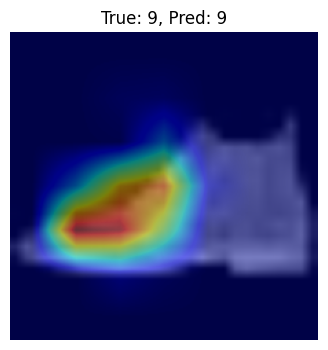

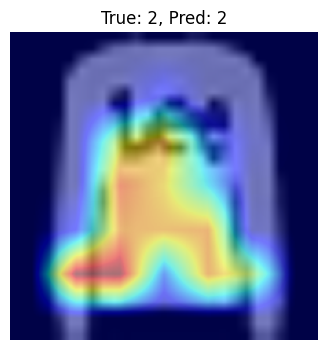

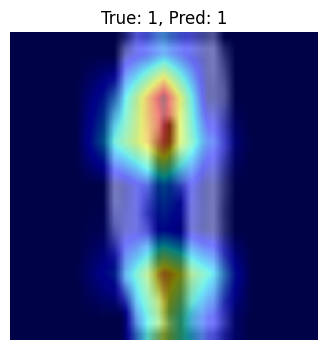

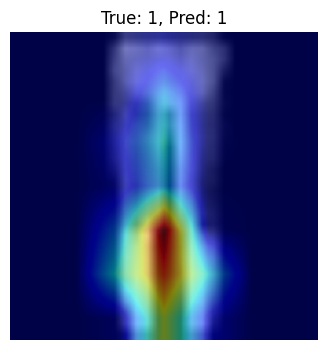

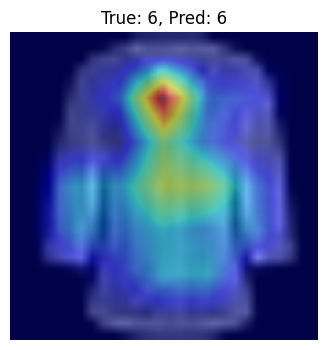

In [59]:
# Visualization
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

for img, true_label, pred_label in examples[:5]:
    cam = grad_cam.generate(img, pred_label)
    cam = cam.unsqueeze(1)

    cam_resized = F.interpolate(
        cam,
        size=img.shape[2:],
        mode="bilinear",
        align_corners=False
    ).squeeze().numpy()

    img_np = img.squeeze().permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    plt.figure(figsize=(4, 4))
    plt.imshow(img_np)
    plt.imshow(cam_resized, cmap="jet", alpha=0.5)
    plt.title(f"True: {true_label.item()}, Pred: {pred_label.item()}")
    plt.axis("off")
    plt.show()

#### Grad-CAM (Correct) Analysis
Grad-CAM visualizations for correctly classified samples show that the ConvNeXt model consistently focuses on class-specific shape regions rather than entire objects. For example, shoe predictions emphasize the toe region, while shirts and sweaters focus on sleeves, shoulders, and upper torso areas. Pants are characterized by attention around the crotch and lower legs.

These highlighted areas align well with cues that separate visually similar classes in Fashion-MNIST (eg. coats/pullovers/shirts). This suggests that the model learns meaningful and relevant features rather than relying on background artifacts or false correlations.

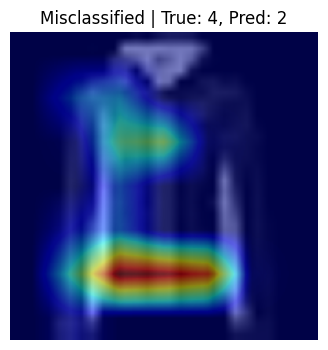

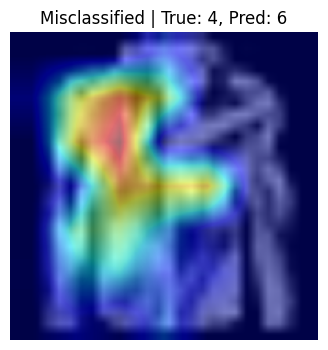

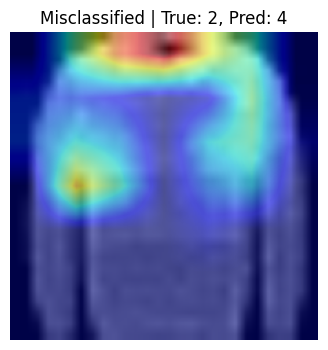

In [63]:
misclassified = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = baseline_model(inputs)
        _, preds = torch.max(outputs, 1)

        for i in range(len(inputs)):
            if preds[i] != labels[i]:
                misclassified.append((inputs[i:i + 1], labels[i], preds[i]))
        if len(misclassified) >= 3:
            break

for img, true_label, pred_label in misclassified[:3]:
    cam = grad_cam.generate(img, pred_label)
    cam = cam.unsqueeze(1)

    cam = F.interpolate(
        cam,
        size=img.shape[2:],
        mode="bilinear",
        align_corners=False
    ).squeeze().cpu().numpy()

    cam = np.maximum(cam, 0)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)

    img_np = img.squeeze().permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

    plt.figure(figsize=(4, 4))
    plt.imshow(img_np)
    plt.imshow(cam, cmap="jet", alpha=0.5)
    plt.title(f"Misclassified | True: {true_label.item()}, Pred: {pred_label.item()}")
    plt.axis("off")
    plt.show()

#### Missclassification Analysis
The above images rshow that most errors occur between visually similar upper-body clothing, particularly coats, pullovers, and shirts. In one example, a coat is misclassified as a pullover, with Grad-CAM highlighting the central torso region while largely ignoring clothing length, a key difference between the two. In another case, a coat is predicted as a shirt, where attention concentrates on a single shoulder region, suggesting over-reliance on sleeve and shoulder cues.

Conversely, a pullover misclassified as a coat shows strong activation around the collar and upper shoulders, indicating that the presence of a pronounced neckline biases the model toward the coat class. These errors suggest that while the model learns meaningful local features, it sometimes underweights global shape cues such as clothing length. This highlights a limitation of feature-extraction-based transfer learning on low-resolution images and motivates future work involving fine-tuning deeper layers or incorporating shape-aware upgrades.

## Scratch CNN

Simple convolutional neural network trained from scratch.
This model serves as a baseline to compare against the pretrained ConvNeXt model
and illustrates the benefit of transfer learning on limited data.


In [28]:
scratch_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [29]:
scratch_train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=scratch_transform
)

scratch_test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=scratch_transform
)

# Train / validation split
val_fraction = 0.1
val_size = int(len(scratch_train_dataset) * val_fraction)
train_size = len(scratch_train_dataset) - val_size

scratch_train_subset, scratch_val_subset = random_split(
    scratch_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

scratch_train_loader = DataLoader(
    scratch_train_subset,
    batch_size=32,
    shuffle=True
)

scratch_val_loader = DataLoader(
    scratch_val_subset,
    batch_size=32,
    shuffle=False
)


In [30]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Input: (batch, 1, 28, 28)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # After 2 pools: 28 → 14 → 7
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [31]:
images, labels = next(iter(scratch_train_loader))
print(images.shape)  # should be [32, 1, 28, 28]

torch.Size([32, 1, 28, 28])


Training CNN over 10 epochs

In [32]:
num_epochs = 10
scratch_model = SimpleCNN(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(scratch_model.parameters(), lr=0.001)

scratch_writer = SummaryWriter('logs/scratch_cnn')

print("\nTraining CNN from scratch...")
scratch_model, scratch_history = train_model(
    model=scratch_model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=scratch_train_loader,
    val_loader=scratch_val_loader,
    num_epochs=num_epochs,
    device=device,
    writer=scratch_writer,
    run_name='scratch_cnn'
)

save_checkpoint(
    scratch_model,
    optimizer,
    num_epochs,
    scratch_history,
    'saved_models/scratch_cnn/checkpoint.pth'
)

scratch_writer.close()


Training CNN from scratch...

Epoch 1/10


Training: 100%|██████████| 1688/1688 [00:17<00:00, 98.16it/s] 


Train Loss: 0.4318 Acc: 0.8452
Val   Loss: 0.3066 Acc: 0.8868

Epoch 2/10


Training: 100%|██████████| 1688/1688 [00:19<00:00, 87.11it/s]


Train Loss: 0.2810 Acc: 0.8982
Val   Loss: 0.2740 Acc: 0.8997

Epoch 3/10


Training: 100%|██████████| 1688/1688 [00:18<00:00, 89.40it/s] 


Train Loss: 0.2358 Acc: 0.9131
Val   Loss: 0.2504 Acc: 0.9070

Epoch 4/10


Training: 100%|██████████| 1688/1688 [00:17<00:00, 98.91it/s] 


Train Loss: 0.2053 Acc: 0.9249
Val   Loss: 0.2326 Acc: 0.9152

Epoch 5/10


Training: 100%|██████████| 1688/1688 [00:16<00:00, 101.83it/s]


Train Loss: 0.1803 Acc: 0.9331
Val   Loss: 0.2289 Acc: 0.9157

Epoch 6/10


Training: 100%|██████████| 1688/1688 [00:18<00:00, 91.60it/s] 


Train Loss: 0.1597 Acc: 0.9400
Val   Loss: 0.2386 Acc: 0.9153

Epoch 7/10


Training: 100%|██████████| 1688/1688 [00:17<00:00, 95.88it/s] 


Train Loss: 0.1407 Acc: 0.9466
Val   Loss: 0.2478 Acc: 0.9117

Epoch 8/10


Training: 100%|██████████| 1688/1688 [00:17<00:00, 96.60it/s] 


Train Loss: 0.1235 Acc: 0.9539
Val   Loss: 0.2385 Acc: 0.9185

Epoch 9/10


Training: 100%|██████████| 1688/1688 [00:17<00:00, 97.90it/s] 


Train Loss: 0.1073 Acc: 0.9597
Val   Loss: 0.2498 Acc: 0.9163

Epoch 10/10


Training: 100%|██████████| 1688/1688 [00:17<00:00, 98.27it/s] 


Train Loss: 0.0929 Acc: 0.9641
Val   Loss: 0.2536 Acc: 0.9197


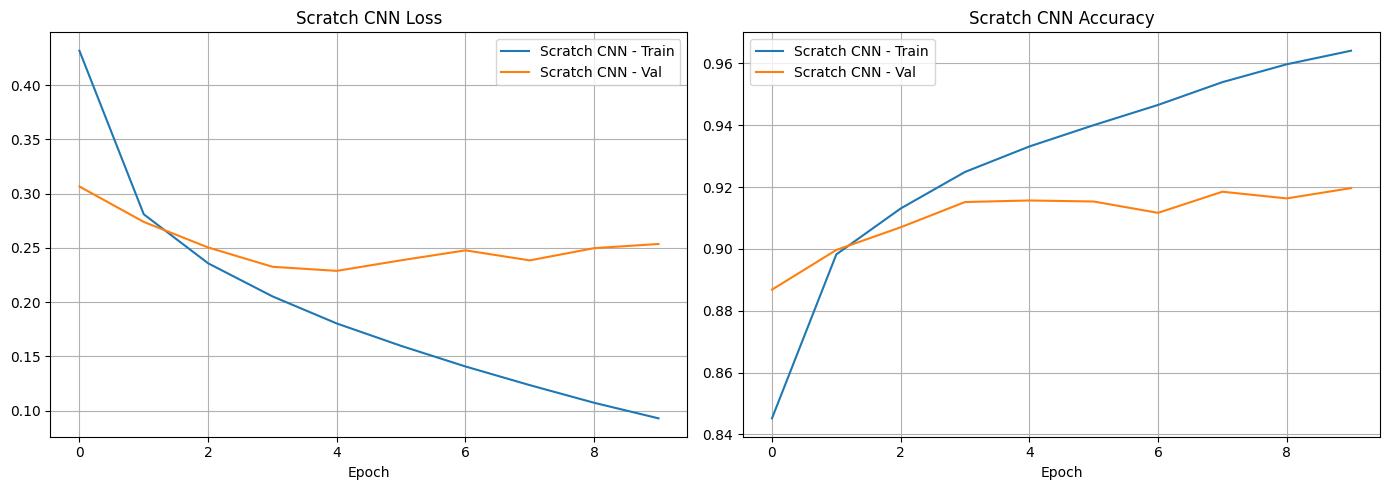

In [33]:
fig = plot_history(scratch_history, 'Scratch CNN')
plt.show()

### CNN – Performance Analysis

The CNN trained from scratch achieves a peak validation accuracy of 91.97%, while training accuracy reaches about 96.4%. The resulting generalization gap of around 4.5% is moderate and expected for a compact CNN trained without pretraining. Importantly, validation accuracy improves steadily throughout training and does not degrade in later epochs (except for small dips in epoch 6 and 8), indicating that the model does not strongly overfit despite its increasing training performance.

This behavior suggests that the network has sufficient capacity to learn meaningful patterns in the data while still generalizing well to unseen samples. Given the simplicity of the architecture and the absence of transfer learning, achieving nearly 92% validation accuracy on Fashion-MNIST can be considered strong performance and provides a solid baseline for comparison with pretrained models.


## Final Model Comparison
The final comparison between the pretrained ConvNeXt model and the CNN trained from scratch highlights an important dataset–model interaction. While ConvNeXt benefits from ImageNet pretraining and achieves strong performance with minimal training, its peak validation accuracy on Fashion-MNIST (≈90%) is slightly lower than that of the custom CNN trained from scratch (≈92%). This result contrasts with typical transfer learning outcomes (Usually a pretrained model converges faster, has higher accuracy, and generalizes better than a pretrained model) but this is explained by the characteristics of the dataset.

Fashion-MNIST consists of low-resolution (28×28), grayscale images with relatively simple textures and well-defined shapes. The scratch CNN operates directly on these native inputs, allowing it to learn task-specific spatial patterns without distortion. In contrast, ConvNeXt requires resizing to 224×224 and RGB conversion, introducing interpolation artifacts and unnecessary complexity. As a result, the model bias for local patterns of a small, purpose-built CNN proves better suited for this dataset than a large pretrained architecture.

Importantly, ConvNeXt still demonstrates good generalization and stable training, confirming the effectiveness of transfer learning even in a constrained setting. However, this comparison shows that pretrained models are not always superior: for small, structured datasets, simpler architectures trained from scratch can outperform more complex models. This reinforces the importance of aligning model choice with data characteristics rather than defaulting to transfer learning.



## In Conclusion:
In this project, we experimented with transfer learning versus training from scratch on the Fashion-MNIST image classification dataset. A pretrained ConvNeXt (tiny) model was tuned using feature extraction and compared against a custom-built CNN trained on raw grayscale images. Through experimentation with tuning learning rate and a Grad-CAM analysis, we demonstrated that both approaches can achieve strong performance, with validation accuracies around 90%.

While ConvNeXt provided stable and interpretable results with minimal training effort, the scratch CNN achieved a higher validation accuracy, showcasing that pretrained models are not always the best choice for small, low-resolution datasets. Grad-CAM visualizations further showed that ConvNeXt learns meaningful features but sometimes over-relies on local cues, leading to misclassifications between visually similar clothing. Overall, our project emphasizes the value of careful model selection, empirical comparison, and interpretability in deep learning workflows.


## Future Work
Several extensions could further improve and deepen our project. First, selectively unfreezing the later ConvNeXt blocks and fine-tuning them with a lower learning rate may allow the pretrained features to better adapt to fashion-specific shapes. Second, alternative preprocessing strategies, such as training ConvNeXt on upscaled grayscale images without RGB duplication, could reduce input distortion and improve performance.

Additionally, experimenting with more advanced data augmentations or shape-aware losses could help the model better capture global clothing structure, potentially reducing confusion between coats, shirts, and pullovers. Finally, extending the evaluation to other pretrained architectures (e.g., ResNet or EfficientNet) would provide a broader comparison and further validate the conclusions drawn from this study.